In [2]:
%%shell
pip install pytorch-lightning --quiet
pip install wandb --quiet
pip install hydra-core --upgrade --quiet
pip install unzip --quiet
pip install ipdb -Uqq

In [3]:
# standardowe pakiety
import os
from os.path import join, isfile
from os import listdir
import numpy as np
from scipy.io import loadmat
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import glob
import ipdb

# Pytorch 
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torch.utils.data as data
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToPILImage, Normalize, Resize, ToTensor

# Pytorch Lightning related imports
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics

# Hydra
import hydra
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

# Weights and Biases
import wandb

In [3]:
! wget http://modelnet.cs.princeton.edu/ModelNet40.zip

--2022-12-09 08:36:52--  http://modelnet.cs.princeton.edu/ModelNet40.zip
Resolving modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)... 128.112.136.74
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://modelnet.cs.princeton.edu/ModelNet40.zip [following]
--2022-12-09 08:36:53--  https://modelnet.cs.princeton.edu/ModelNet40.zip
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039180837 (1.9G) [application/zip]
Saving to: ‘ModelNet40.zip’

ModelNet40.zip      100%[===================>]   1.90G  40.7MB/s    in 58s     

2022-12-09 08:37:51 (33.6 MB/s) - ‘ModelNet40.zip’ saved [2039180837/2039180837]



In [4]:
%%shell
cd /content/
mkdir model
unzip -qq /content/ModelNet40.zip -d /content/model

In [4]:
def read_off(file):
    firstLine = file.readline().strip()
    if 'OFF' != firstLine[0:3]:
        raise ValueError('Not a valid OFF header')
    if len(firstLine) > 3:
        n_verts, n_faces, n_edges = tuple([int(s) for s in firstLine[4:].split(' ')])
    else:
        n_verts, n_faces, n_edges = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    #faces = [[float(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts

myF = open('/content/model/ModelNet40/airplane/train/airplane_0012.off', 'r')
#myF = open('/content/testModelNet/airplane/train/airplane_0008.off', 'r')
V, F = read_off(myF)

fig = plt.figure(figsize=(10, 10))

ax = plt.axes(projection='3d')

V_np = np.asarray(V)
xx = V_np[:, 0]
yy = V_np[:, 1]
zz = V_np[:, 2]

ax.scatter(xx, yy, zz)
plt.axis('off')
plt.show()

ValueError: ignored

In [5]:
def default_loader(path):
    myF = open(path, 'r')
    firstLine = myF.readline().strip()
    if 'OFF' != firstLine[0:3]:
        raise ValueError('Not a valid OFF header')
    if len(firstLine) > 3:
        n_verts, n_faces, n_edges = tuple([int(s) for s in firstLine[4:].split(' ')])
    else:
        n_verts, n_faces, n_edges = tuple([int(s) for s in myF.readline().strip().split(' ')])
    verts = [[torch.tensor(float(s)) for s in myF.readline().strip().split(' ')] for i_vert in range(n_verts)] #TU JEST ROBIONY TO TENSOR
    #faces = [[int(s) for s in myF.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts

def default_flist_reader(flist):
    imlist = []
    for line in flist:
        main_data_folder_string = "./model/ModelNet40/"
        label_start_index = line.strip().find(main_data_folder_string) + len(main_data_folder_string)
        label_end_index = line.strip()[label_start_index:].find('/')
        imlabel = line.strip()[label_start_index:label_start_index+label_end_index]
        impath = line
        imlist.append( (impath, imlabel) )
    return imlist

class ModelNetFileList(data.Dataset):
	def __init__(self, root, flist, transform=None, target_transform=None,
			flist_reader=default_flist_reader, loader=default_loader):
		self.root   = root
		self.imlist = flist_reader(flist)		
		self.transform = transform
		self.target_transform = target_transform
		self.loader = loader

	def __getitem__(self, index):
		impath, target = self.imlist[index]
		#img = self.loader(os.path.join(self.root,impath))
		obj = self.loader(impath)
    #if self.transform is not None:
		#	img = self.transform(img)
		#if self.target_transform is not None:
		#	target = self.target_transform(target)
		return obj, target

	def __len__(self):
		return len(self.imlist)

In [6]:
class ModelNetDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './model/ModelNet40/'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_classes = 40
        self.imglist = [f1 for f1 in glob.glob(data_dir + '**/*.off', recursive=True)]# if isfile(join(self.data_dir, f1))]
        self.trainlist = [f2 for f2 in self.imglist if "train" in f2]
        self.testlist = [f3 for f3 in self.imglist if "test" in f3]

    def setup(self, stage=None):
        #training / validation
        if stage == 'fit' or stage is None:
            train_dataset = ModelNetFileList(root=self.data_dir, flist=self.trainlist)
            train_dataset_size = int(len(train_dataset) * 0.9)
            self.train_dataset, self.val_dataset = random_split(train_dataset, [train_dataset_size, len(train_dataset) - train_dataset_size])
        #testing
        if stage == 'test' or stage is None:
            self.test_dataset = ModelNetFileList(root=self.data_dir, flist=self.testlist)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

Rozmiar zbioru: 8858


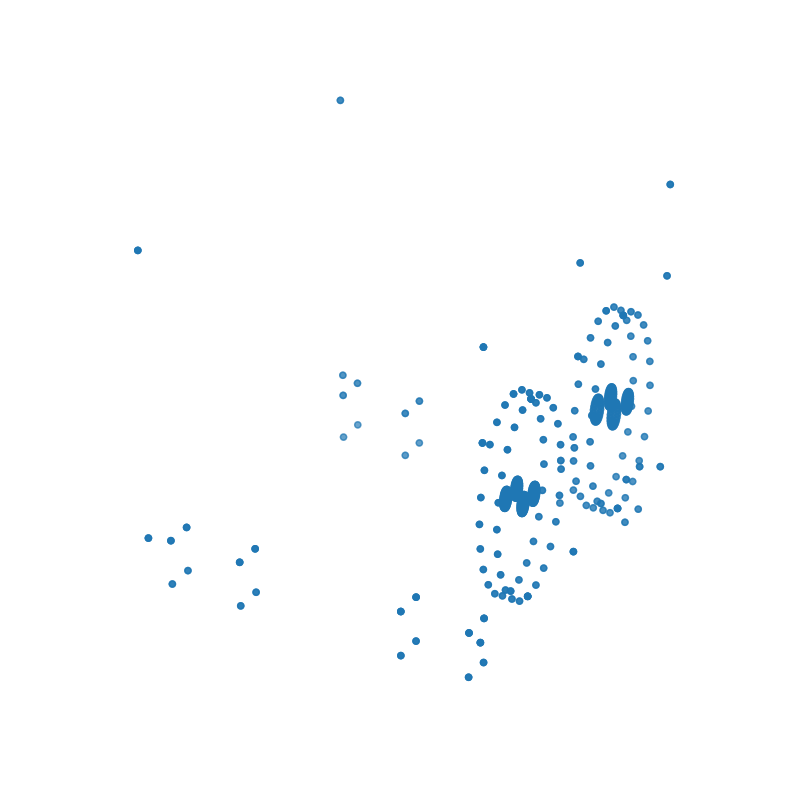

Etykieta klasy: tv_stand



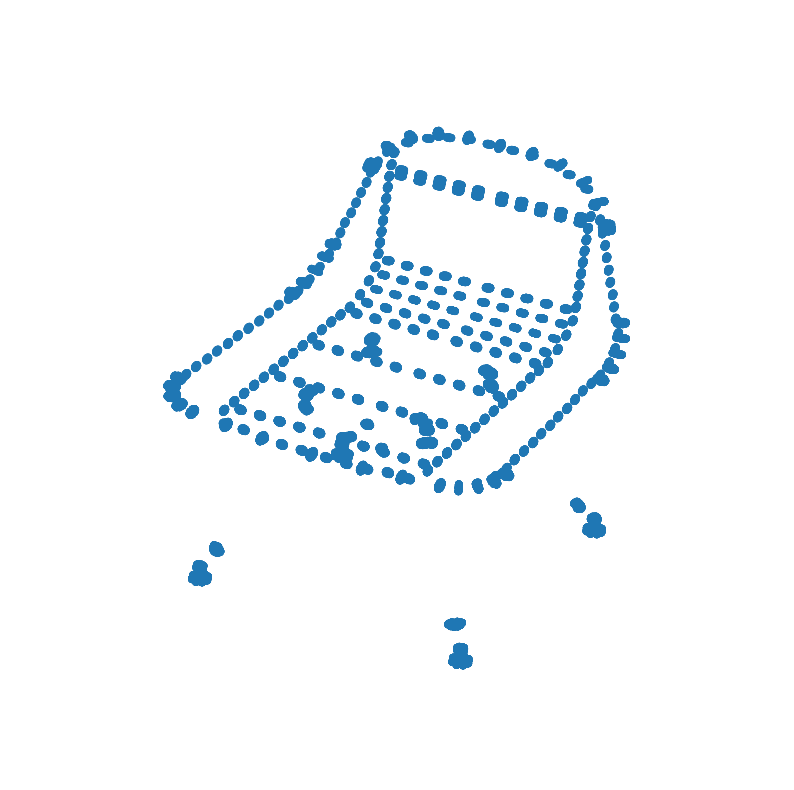

Etykieta klasy: chair



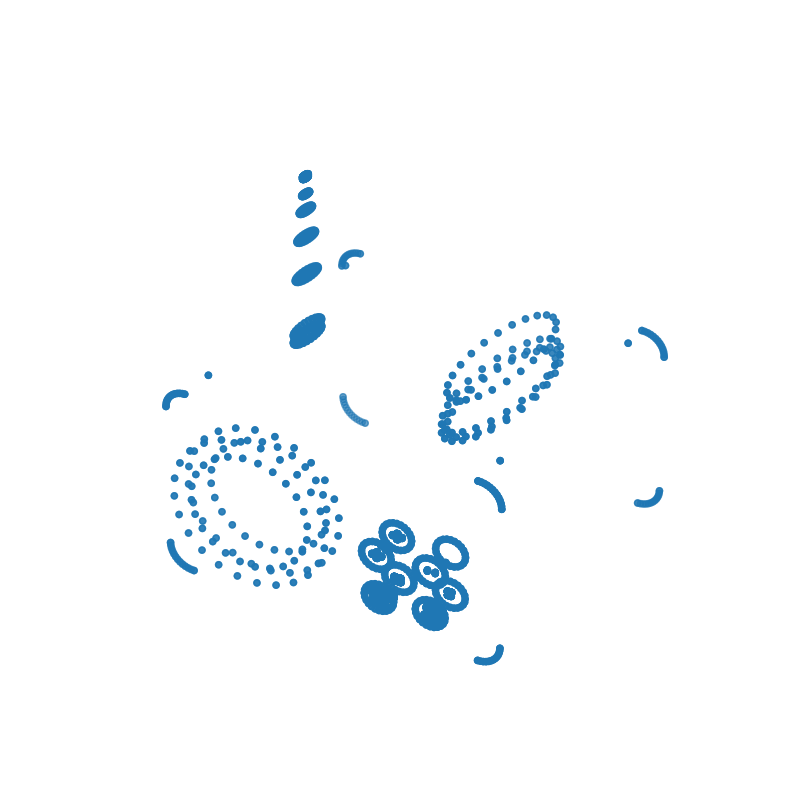

Etykieta klasy: radio



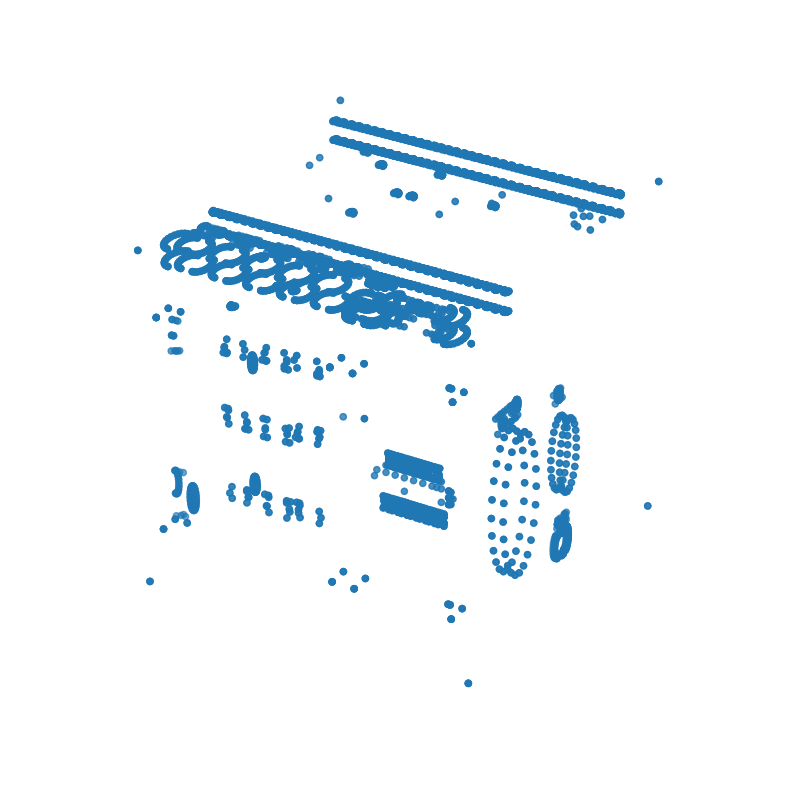

Etykieta klasy: radio



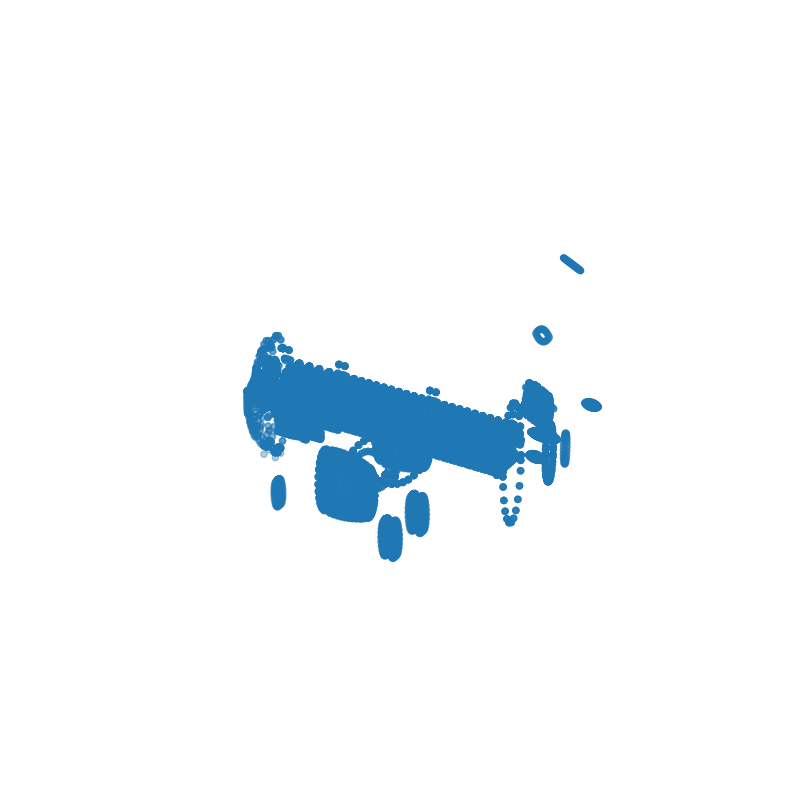

Etykieta klasy: airplane



In [8]:
#%pdb on

sample_data = ModelNetDataModule(10)
sample_data.setup()
print("Rozmiar zbioru: " + str(len(sample_data.train_dataset)))

def show_examples(dataset, n):
    for i in range(n):
        tensor_image, target = random.choice(dataset)

        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes(projection='3d')
        V_np = np.asarray(tensor_image)
        #ipdb.set_trace(context=4)
        #print(V_np.size)
        #print(V_np)
        xx = V_np[:, 0]
        yy = V_np[:, 1]
        zz = V_np[:, 2]
        ax.scatter(xx, yy, zz)
        plt.axis('off')
        plt.show()

        print('Etykieta klasy: {}'.format(target))
        print()
  
show_examples(sample_data.train_dataset, 5)

In [ ]:
class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)



```python
class STN3d(nn.Module):
  output:
    stn torch.Size([32, 3, 3])global feat torch.Size([32, 1024])classification head:
      global feat torch.Size([32, 1024])
      point feat torch.Size([32, 1088, 2500])
      class torch.Size([32, 5])segmentation head:
        PointNetDenseCls(
          (feat): PointNetfeat(
            (stn): STN3d(
              (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
              (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
              (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
              (mp1): MaxPool1d(kernel_size=2500, stride=2500, padding=0, dilation=1, ceil_mode=False)
              (fc1): Linear(in_features=1024, out_features=512, bias=True)
              (fc2): Linear(in_features=512, out_features=256, bias=True)
              (fc3): Linear(in_features=256, out_features=9, bias=True)
              (relu): ReLU()
              (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
            (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
            (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
            (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (mp1): MaxPool1d(kernel_size=2500, stride=2500, padding=0, dilation=1, ceil_mode=False)
          )
          (conv1): Conv1d(1088, 512, kernel_size=(1,), stride=(1,))
          (conv2): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
          (conv3): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
          (conv4): Conv1d(128, 3, kernel_size=(1,), stride=(1,))
          (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
  seg torch.Size([32, 2500, 3])
```